In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import xml.etree.ElementTree as xet

In [2]:
df = pd.read_csv("dataset/label.csv")

df.head()

,filepath,xmin,xmax,ymin,ymax
0,dataset\labels_1\Cars0.xml,216,435,114,182
1,dataset\labels_1\Cars1.xml,130,268,122,165
2,dataset\labels_1\Cars10.xml,22,352,18,179
3,dataset\labels_1\Cars11.xml,116,294,196,242
4,dataset\labels_1\Cars12.xml,119,281,79,120


In [3]:
filename = df["filepath"][0]
filename

'dataset\\labels_1\\Cars0.xml'

In [4]:
xet.parse(filename).getroot().find("filename").text

'Cars0.png'

In [7]:
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find("filename").text
    filepath_image = os.path.join("dataset/labels_1",filename_image)
    return filepath_image

In [8]:
getFilename(filename)

'dataset/labels_1\\Cars0.png'

In [9]:
images_path = list(df["filepath"].apply(getFilename))
images_path[:5]

['dataset/labels_1\\Cars0.png',
 'dataset/labels_1\\Cars1.png',
 'dataset/labels_1\\Cars10.png',
 'dataset/labels_1\\Cars11.png',
 'dataset/labels_1\\Cars12.png']

## Verify Image 

(-0.5, 499.5, 267.5, -0.5)

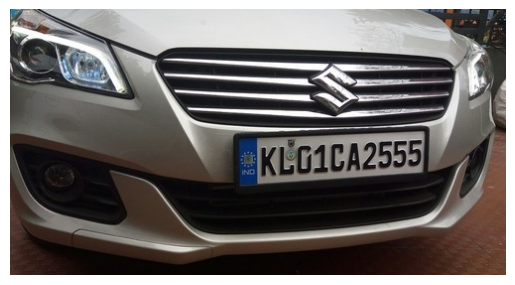

In [10]:
filepath = images_path[0]

img = cv2.imread(filepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cv2.rectangle(img, (1093,645), (1396,727), (0,255,0), 5)
plt.imshow(img)
plt.axis("off")

## Data Preprocessing

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [12]:
labels = df.iloc[:,1:].values
labels[:5]

array([[216, 435, 114, 182],
       [130, 268, 122, 165],
       [ 22, 352,  18, 179],
       [116, 294, 196, 242],
       [119, 281,  79, 120]], dtype=int64)

In [13]:
data = []
output = []
for ind in range(len(images_path)):
    ind = 0
    image = images_path[ind]
    image_arr = cv2.imread(image)
    h,w,d = image_arr.shape

    # preprocessing
    load_image = load_img(image, target_size=(224,224))
    load_img_arr = img_to_array(load_image)
    norm_load_img_arr = load_img_arr/255.0 # normalization

    # normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w, xmax/w
    nymin,nymax = ymin/h, ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # normalized output
    
    # append
    data.append(norm_load_img_arr)
    output.append(label_norm)    

In [14]:
X = np.array(data, dtype=np.float32)
y = np.array(output, dtype=np.float32)

In [15]:
X.shape, y.shape

((44, 224, 224, 3), (44, 4))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35, 224, 224, 3), (9, 224, 224, 3), (35, 4), (9, 4))

## Deep Learning Model

In [17]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [18]:
inception_resnet = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

inception_resnet.trainable = False

### NETWORK ###
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(512, activation="relu")(headmodel)
headmodel = Dropout(0.4)(headmodel)
headmodel = Dense(256, activation="relu")(headmodel)
headmodel = Dropout(0.4)(headmodel)
headmodel = Dense(64, activation="relu")(headmodel)
headmodel = Dropout(0.4)(headmodel)
headmodel = Dense(32, activation="relu")(headmodel)
headmodel = Dropout(0.4)(headmodel)
headmodel = Dense(4, activation="sigmoid")(headmodel)

### MODEL ###
model = Model(inputs=inception_resnet.input, outputs=headmodel)

In [19]:
### COMPILE THE MODEL ###
model.compile(loss="mse", optimizer=tf.optimizers.Adam(learning_rate=1e-4))
#model.summary()

## Training

In [20]:
from tensorflow.keras.callbacks import TensorBoard

In [21]:
tfb = TensorBoard(log_dir="logs")

In [22]:
history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=300, validation_data=(X_test, y_test), callbacks=[tfb])

Epoch 1/300
3/3 [==============================] - 33s 7s/step - loss: 0.1484 - val_loss: 0.0464
Epoch 2/300
3/3 [==============================] - 8s 2s/step - loss: 0.1668 - val_loss: 0.0462
Epoch 3/300
3/3 [==============================] - 8s 2s/step - loss: 0.1714 - val_loss: 0.0538
Epoch 4/300
3/3 [==============================] - 7s 2s/step - loss: 0.1864 - val_loss: 0.0534
Epoch 5/300
3/3 [==============================] - 7s 2s/step - loss: 0.1810 - val_loss: 0.0496
Epoch 6/300
3/3 [==============================] - 7s 2s/step - loss: 0.1766 - val_loss: 0.0487
Epoch 7/300
3/3 [==============================] - 8s 3s/step - loss: 0.1680 - val_loss: 0.0724
Epoch 8/300
3/3 [==============================] - 8s 3s/step - loss: 0.1740 - val_loss: 0.0999
Epoch 9/300
3/3 [==============================] - 7s 2s/step - loss: 0.1849 - val_loss: 0.1155
Epoch 10/300
3/3 [==============================] - 7s 2s/step - loss: 0.1780 - val_loss: 0.1181
Epoch 11/300
3/3 [====================

In [23]:
model.save("dataset/object_detection_v2.h5")

c:\Users\rajna\anaconda3\envs\yolo\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
